In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import math

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

In [2]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """

    right_x = []         # x-values of the lines of the equivalence class "right lane"
    right_y = []         # y-values of the lines of the equivalence class "right lane"
    right_min_x = 1000   # keep in mind: (0,0) is the upper left corner!
    right_max_x = 0      # keep in mind: (0,0) is the upper left corner!
    
    left_x = []          # x-values of the lines of the equivalence class "left lane"
    left_y = []          # y-values of the lines of the equivalence class "left lane"
    left_min_x = 1000    # keep in mind: (0,0) is the upper left corner!
    left_max_x = 0       # keep in mind: (0,0) is the upper left corner!
    
    # iterate through all lines
    for line in lines:
        for x1,y1,x2,y2 in line:
            if x2-x1 != 0:  # ignore vertical lines - might remove relevant lines, but most likely  
                            # not all lines are super vertical    
                slope = (y2-y1)/(x2-x1)
                length = math.sqrt(abs((y2-y1)*(x2-x1)))  # I ignore small lines < 10 (actually the function
                                                          # hough_lines should already do this job also)
                    
                # now divide the lanes into two equivalence classes: with positic slope and with negative slope
                # this works only in rare cases where you have only 2 road lines being detected
                if slope<0 and length>10:
                    if x2<left_min_x:
                        left_min_x = x2
                    if x1<left_min_x:
                        left_min_x = x1
                    if x2>left_max_x:
                        left_max_x = x2
                    if x1>left_max_x:
                        left_max_x = x1

                    # now appending values to list for further polynomial fit
                    left_x.append(x1)
                    left_y.append(y1)
                    left_x.append(x2)
                    left_y.append(y2)
                    
                    # draw all line segments in blue thin color
                    #cv2.line(img,(x1,y1),(x2,y2),[0, 0, 255],3)
                elif slope>0 and length>10:
                    if x2<right_min_x:
                        right_min_x = x2
                    if x1<right_min_x:
                        right_min_x = x1
                    if x2>right_max_x:
                        right_max_x = x2
                    if x1>right_max_x:
                        right_max_x = x1

                    # now appending values to list for further polynomial fit
                    right_x.append(x1)
                    right_y.append(y1)
                    right_x.append(x2)
                    right_y.append(y2)

                    # draw all line segments in blue thin color
                    #cv2.line(img,(x1,y1),(x2,y2),[0, 0, 255],3)    
                    
    # now execute the polynomial fit: in case we are sure that we really have two equivalence classes
    # this works out very nicely!! But it will miserably fail in case there are more than two lines 
    # to be detected in the picture
    if len(left_x) > 0 and len(left_y) >0:
        slope_left, intercept_left = np.polyfit(left_x, left_y, 1)

        # now draw the thick lines on left side and on right side by calculating 
        # the minimal x-axis points in the picture
        # Attention: of course it would be easily possible to extrapolate until the bottom 
        #            of the picture but I felt it would be somehow wrong....
        #            In that case left_min_x = right_min_x == img.shape[0] and code the above would be even simpler   
        cv2.line(img, (int(left_min_x), int(left_min_x*slope_left+intercept_left)), (int(left_max_x), int(left_max_x*slope_left+intercept_left)), color, thickness)

    # now execute the polynomial fit: in case we are sure that we really have two equivalence classes
    # this works out very nicely!! But it will miserably fail in case there are more than two lines 
    # to be detected in the picture
    if len(right_x) > 0 and len(right_y) >0:
        slope_right, intercept_right = np.polyfit(right_x, right_y, 1)

        # now draw the thick lines on left side and on right side by calculating 
        # the minimal x-axis points in the picture
        # Attention: of course it would be easily possible to extrapolate until the bottom 
        #            of the picture but I felt it would be somehow wrong....
        #            In that case left_min_x = right_min_x == img.shape[0] and code the above would be even simpler   
        cv2.line(img, (int(right_min_x), int(right_min_x*slope_right+intercept_right)), (int(right_max_x), int(right_max_x*slope_right+intercept_right)), color, thickness)
   
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

Test

In [3]:
def process_image(initial_img):
    """
    `initial_img` should be the image before any processing.
    """
   
    # First: define the grayscaled picture including the gaussian blur
    gray = grayscale(initial_img)
    blur_gray = gaussian_blur(gray , 3)

    # Second: Apply Canny algorithm with ration 1:3 between lower threshold and higher threshold
    edges = canny(blur_gray,50,150) 

    # Third: define the vertices for the region of interest
    # Apex is the vanishing point ("Fluchtpunkt")
    imshape = initial_img.shape
    apex = [imshape[1]/2 , imshape[0]/2]
    
    # Actually I'm not really happy about hardcoding the vertices - but it seems to work fine with 
    # pictures of this size.... The orientation and angle of the camera doesn't change over time usually 
    vertices = np.array([[(90,imshape[0]),(460,322), (500,322), (900,imshape[0])]], dtype=np.int32)
    
    # I was really struggling whether it is better to do selection of the region of interest
    # before or after the Hough transformation - but seems to work perfectly fine for these examples....
    # - possible advantage of doing region selection before: less effort for Hough transformation
    # - possible disadvantage of doing region selection before: in case the re-transformation would return 
    #                                                           lines outside the region of interest I have to
    #                                                           apply region selection again
    # Should check this again when I have more time..... ;-)
    image_region = region_of_interest(edges,vertices)
    
    # Fourth: transformation into Hough space
    #hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    image_hough = hough_lines(image_region, 2, np.pi/180, 30, 100, 160)

    # Fifth: Overlay the pictures
    image_overlay = weighted_img(image_hough, initial_img)
    return image_overlay

In [4]:
files = os.listdir("../test_images/")

    

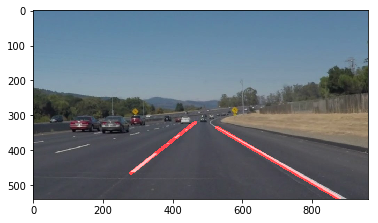

In [5]:
image = mpimg.imread("../test_images/"+files[0])
result_image = process_image(image)
plt.imshow(result_image)

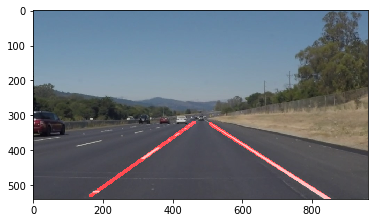

In [6]:
image = mpimg.imread("../test_images/"+files[1])
result_image = process_image(image)
plt.imshow(result_image)

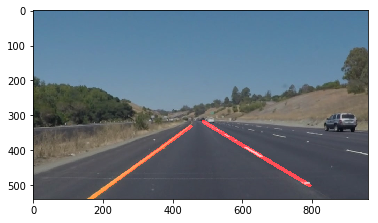

In [7]:
image = mpimg.imread("../test_images/"+files[2])
result_image = process_image(image)
plt.imshow(result_image)

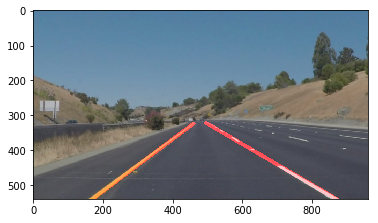

In [8]:
image = mpimg.imread("../test_images/"+files[3])
result_image = process_image(image)
plt.imshow(result_image)

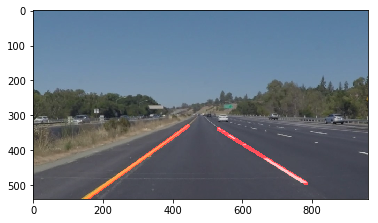

In [9]:
image = mpimg.imread("../test_images/"+files[4])
result_image = process_image(image)
plt.imshow(result_image)

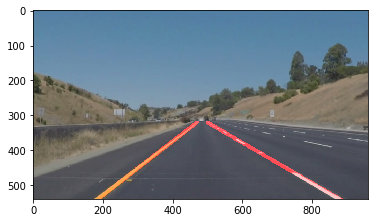

In [10]:
image = mpimg.imread("../test_images/"+files[5])
result_image = process_image(image)
plt.imshow(result_image)

In [11]:
white_output = 'white.mp4'
clip1 = VideoFileClip("../solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:03<00:00, 70.11it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 3.51 s


In [12]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip("../solidYellowLeft.mp4")
yellow_clip = clip2.fl_image(process_image) #NOTE: this function expects color images!!
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:09<00:00, 74.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 9.76 s


In [ ]:
challenge_output = 'extra.mp4'
clip3 = VideoFileClip("../challenge.mp4")
challenge_clip = clip3.fl_image(process_image) #NOTE: this function expects color images!!
%time challenge_clip.write_videofile(challenge_output, audio=False)